In [4]:
% matplotlib inline

import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

In [5]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [6]:
# import data directly from myria

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-tot_chl_byfile/data?format=csv'
result = pd.read_csv(fileURL)
# pick out the subset of variables to use for clustering/PCA
print result.columns

fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
sds = pd.read_csv(fileURL)
sds.rename(columns={'file': 'File_Id', 'day': 'Day'}, inplace=True)
print sds.columns


Index([u'tot_chl', u'Cruise', u'Day', u'File_Id'], dtype='object')
Index([u'Day', u'LAT', u'LON', u'File_Id', u'T', u'S', u'Cruise'], dtype='object')


In [7]:
# join sds dataframe to opp file averages

print sds.shape
#print type(sds), type(cIdx[9])
#new_table = pd.merge(sds, result, how="inner")
new_table = pd.merge(sds, result, how="inner")


#X = new_table[['fsc_avg','chl_avg','pe_avg','fsc_var','chl_var','pe_var']].values  
X = new_table[['tot_chl']].values 

(69235, 7)


In [63]:
# identify continuous transects
# start by just picking out cruises that we know fit the bill

# look at how the clusters relate to physical properties of the water column...

cr = 'Thompson_1'
crsub = new_table[(new_table['Cruise']==cr)].sort(['Day','File_Id'],ascending=[1,1])
crsub['density'] = sw.rho(crsub['S'].values,crsub['T'].values,0)

cxx = (crsub['LON']).values # longitude
cyy = (crsub['LAT']).values # latitude

# convert all longitude to longitude east
cxx[cxx<0]= 360+cxx[cxx<0];
cxbew = cxx
cxbew[cxbew>180] = cxbew[cxbew>180]-360

# calculate distance between points
cdistance = sw.distance(cxbew,cyy, 0)[0]
ctrack = np.cumsum(cdistance)
ctrack = np.insert(ctrack, 0, 0)


1.31809837483
1.39471233332


In [81]:
# "continuous" tracks of data are found between 63:950 952:1015 1017:1371
# now turn these into 3 separate datasets, track1, track2 and track3
# check the lemgth of these tracks

t1 = ctrack[950]-ctrack[63] #1169km long
t2 = ctrack[1015]-ctrack[952] #124km long
t3 = ctrack[1371]-ctrack[1017] #442km long

# split the subset into tracks
t1sub = crsub.iloc[63:950]
t3sub = crsub.iloc[1017:1371]

# split the tracks
t1track = ctrack[63:950]-ctrack[63]
t2track = ctrack[1017:1371]-ctrack[1017]


# check the effective resolution for the tracks
print cdistance[63:950].mean()/1000, cdistance[63:950].std()/1000
print cdistance[1017:1371].mean()/1000, cdistance[1017:1371].std()/1000



124.330841079
1.31809837483 0.819075028234
1.24845750829 0.555650023703


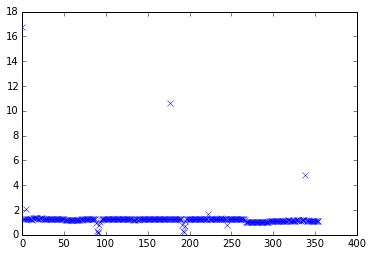

In [78]:
plt.plot(cdistance[1016:1371]/1000,'x')
plt.show()